In [103]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3
from collections import namedtuple
import matplotlib as mpl 
import matplotlib.pyplot as plt
from matplotlib import rc
from scipy.stats import linregress
import imageio
import seaborn as sns

%matplotlib inline

# Optionally, tweak styles.
rc('animation', html='html5')
mpl.rc('figure',  figsize=(5, 10))
mpl.rc('image', cmap='gray')
import numpy as np
import pandas as pd
import trackpy as tp

from pandas import DataFrame, Series  # for convenience
import os
from ntpath import basename

import pims
import glob
from sxmreader import SXMReader

Params = namedtuple(
    'Params', 
    ['molecule_size', 
     'min_mass',
     'max_mass',
     'separation',
     'min_size',
     'max_ecc',
     'adaptive_stop',
     'search_range'])

voltage = np.linspace(0.65, 0.9, 6, dtype=np.float32)
START = 16
SIZE = 15
sets = [range(START + SIZE * i, START + SIZE * (i + 1)) for i in range(len(voltage))]
params = [
     Params(molecule_size = 11,
            min_mass = 2,
            max_mass = 8,
            min_size = 0.5,
            max_ecc = 1,
            separation = 5,
            search_range = 100,
            adaptive_stop = 2,
           ) for i in range(len(voltage))
         ]
n_range = [i for i in sets]
N = [len(i) for i in sets]
SXM_PATH = [["electromigration_19/Image_{0:03}.sxm".format(i) for i in n_range[j]] for j in range(len(n_range))]

In [104]:
[range(START + SIZE * i, START + SIZE * (i + 1)) for i in range(len(voltage))]

[range(16, 31),
 range(31, 46),
 range(46, 61),
 range(61, 76),
 range(76, 91),
 range(91, 106)]

In [105]:
drifts = []
D_constants = []
mu_hats = []
for i, path in enumerate(SXM_PATH):
    frames = SXMReader(path)
    NM_PER_PIXEL = frames.meters_per_pixel * 1e9 
    molecule_size, min_mass, max_mass, separation, min_size, max_ecc, adaptive_stop, search_range = params[i]
    f = tp.batch(frames[:], molecule_size, minmass=min_mass, separation=separation)
    t = tp.link(f, search_range=search_range, adaptive_stop=adaptive_stop)
#     t = tp.link(f, search_range=search_range)
    t1 = t[((t['mass'] > min_mass) & (t['size'] > min_size) &
         (t['ecc'] < max_ecc)) & (t['mass'] < max_mass)]
    t2 = tp.filter_stubs(t, 3)
    # Compare the number of particles in the unfiltered and filtered data.
    print('Before:', t['particle'].nunique())
    print('After:', t2['particle'].nunique())
    d = tp.compute_drift(t2)
    t3 = t2.copy()
    displacements = tp.relate_frames(t3, 0, 1) * NM_PER_PIXEL
    for j in range(t3.frame.max() - 1):
        displacements = displacements.append(tp.relate_frames(t3, j, j + 1) * NM_PER_PIXEL, ignore_index=True)
    D_constants.append((displacements.dx.var() + displacements.dy.var()) / 4) # r^2 = x^2 + y^2 = 2Dt + 2Dt
    mu_hats.append(np.mean(displacements[['dx', 'dy']], axis=0))
    d.loc[0] = [0, 0]
    drifts.append(d)
    # print(d)


Frame 14: 15 trajectories present.
Before: 47
After: 31


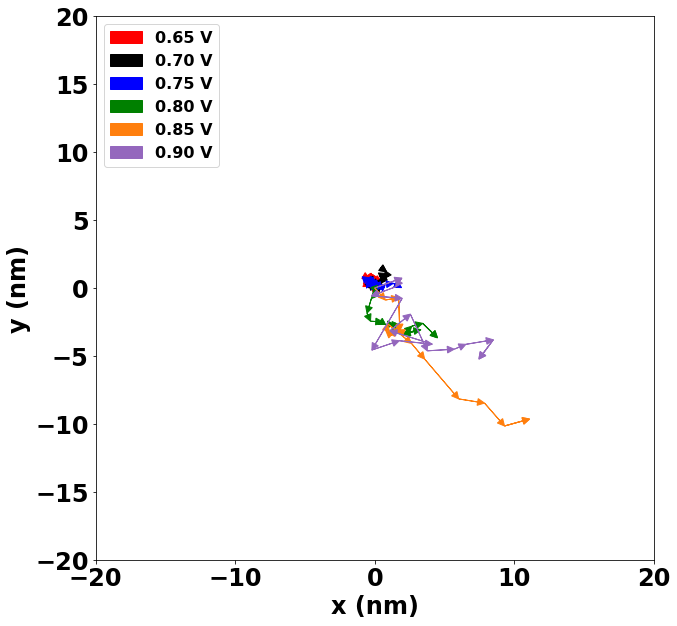

In [106]:
mpl.rcParams.update({'font.size': 24, 'font.weight':'bold'})
plt.figure(figsize=(10, 10))
colors = ['r', 'k', 'b', 'g', 'tab:orange', 'tab:purple', 'm']
arrs = []
j = 0
for d in drifts:
#     sns.scatterplot(x='x', y='y', data=d * NM_PER_PIXEL, alpha=0.0)
    for i in range(1, len(d)):
        d0, d1 = d.loc[i - 1] * NM_PER_PIXEL, d.loc[i] * NM_PER_PIXEL
        plt.arrow(d0.x,d0.y,d1.x-d0.x, d1.y-d0.y, 
        shape='full', color=colors[j], length_includes_head=True, 
        zorder=0, head_length=0.5, head_width=0.5,linewidth=1)
    else:
        d0, d1 = d.loc[i - 1] * NM_PER_PIXEL, d.loc[i] * NM_PER_PIXEL
        arrs.append(plt.arrow(d0.x,d0.y,d1.x-d0.x, d1.y-d0.y, 
        shape='full', color=colors[j], length_includes_head=True, 
        zorder=0, head_length=0.5, head_width=0.5, label=str(voltage[j])))
    j += 1
new_labels, arrs = zip(*sorted(zip(voltage, arrs)))
new_labels=["{:.2f}".format(s) + ' V' for s in new_labels]
plt.legend(arrs, new_labels, fontsize=16, loc='upper left')
#plt.title("Ensemble Drift, " + SXM_PATH[0][0] + " to {}".format(SXM_PATH[-1][-1]))
plt.xlabel("x (nm)",fontsize=24,fontweight='bold')
plt.ylabel("y (nm)",fontsize=24,fontweight='bold')
plt.xlim(-20, 20)
plt.ylim(-20, 20)
plt.show()

Text(0.5, 0, 'Voltage (V)')

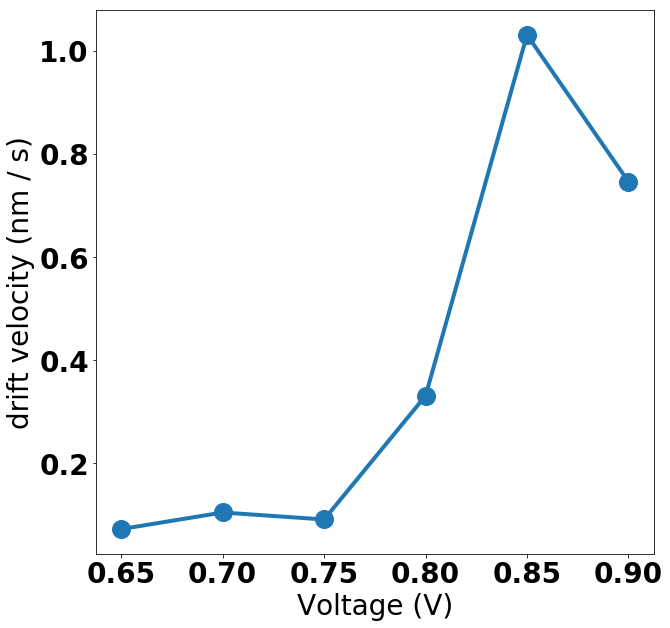

In [108]:
import scipy
DIFFUSION_TIME = 1 # in seconds
mag_displace = np.linalg.norm(mu_hats, 2, axis=1)
new_labels, n_mag_displace, ord_D_constants = zip(*sorted(zip(voltage, mag_displace, D_constants)))
import matplotlib
matplotlib.rcParams.update({'font.size' : 28, 'font.weight' : 'bold'})
plt.figure(figsize=(10, 10))
plt.plot(voltage, mag_displace / DIFFUSION_TIME, '-o', markersize=18, linewidth=4)
# plt.plot(xx, yy / 1.5)
plt.ylabel('drift velocity (nm / s)')
plt.xlabel('Voltage (V)')

In [109]:
mag_displace

array([0.07271994, 0.10490607, 0.09135322, 0.33101666, 1.03049401,
       0.74599307])

Text(0.5, 0, 'Voltage (V)')

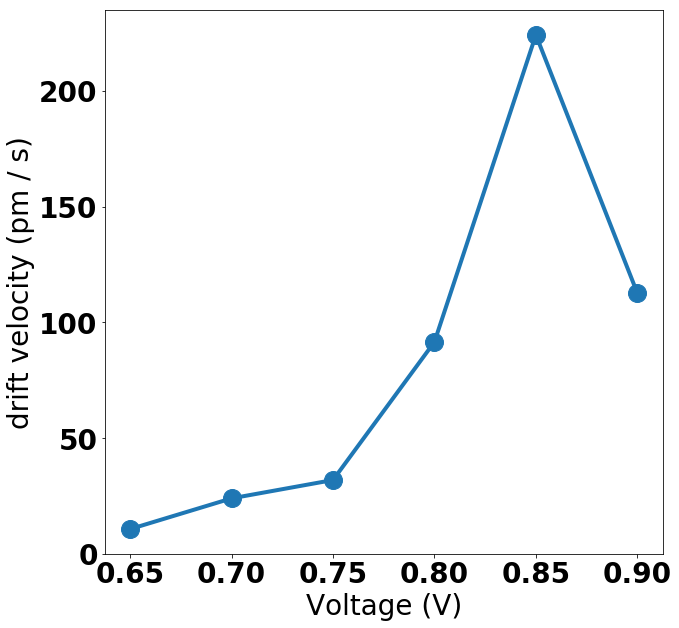

In [97]:
import scipy
DIFFUSION_TIME = 1 # in seconds
endpoints = np.array([d.iloc[-2] * NM_PER_PIXEL / DIFFUSION_TIME for d in drifts])
mag_displace = np.linalg.norm(endpoints, 2, axis=1)
new_labels, n_mag_displace, ord_D_constants = zip(*sorted(zip(voltage, mag_displace, D_constants)))
def exponential_func(x, a, b):
    return a*np.exp(-b*x)

# popt, pcov = scipy.optimize.curve_fit(exponential_func, new_labels, mag_displace)

# xx = np.linspace(0.9, 1.4, 100)
# yy = exponenial_func(xx, *popt)
import matplotlib
matplotlib.rcParams.update({'font.size' : 28, 'font.weight' : 'bold'})
plt.figure(figsize=(10, 10))
plt.plot(voltage, mag_displace * 1e3, '-o', markersize=18, linewidth=4)
# plt.plot(xx, yy / 1.5)
plt.ylabel('drift velocity (pm / s)')
plt.xlabel('Voltage (V)')

In [77]:
ds = [0.01879390399510874,
 0.05081455484071236,
 0.1422569480594092,
 0.22665997294778575,
 0.43412316193393957]
plt.figure(figsize=(10, 10))
plt.plot(voltage, mag_displace / ds)
plt.xlabel('voltage')

ValueError: operands could not be broadcast together with shapes (6,) (5,) 

<Figure size 720x720 with 0 Axes>

NameError: name 'exponential_func' is not defined

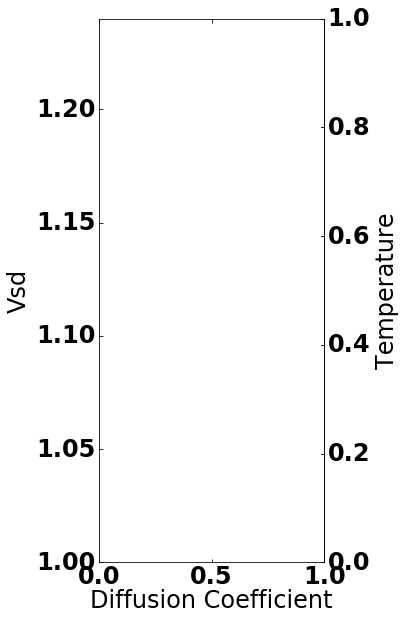

In [78]:
"""
Parasite axis demo

The following code is an example of a parasite axis. It aims to show a user how
to plot multiple different values onto one single plot. Notice how in this
example, par1 and par2 are both calling twinx meaning both are tied directly to
the x-axis. From there, each of those two axis can behave separately from the
each other, meaning they can take on separate values from themselves as well as
the x-axis.
"""
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import matplotlib.pyplot as plt

host = host_subplot(111, axes_class=AA.Axes)
plt.subplots_adjust(right=0.75)

par1 = host.twinx()
par2 = host.twinx()

offset = 0
new_fixed_axis = par2.get_grid_helper().new_fixed_axis
par2.axis["right"] = new_fixed_axis(loc="right",
                                    axes=par2,
                                    offset=(offset, 0))

par2.axis["right"].toggle(all=True)

host.set_xlabel("Diffusion Coefficient")
host.set_ylabel("Vsd")
host.set_ylim(1, 1.24)
par1.set_ylabel("Temperature")
par2.set_ylabel("Temperature")
Vsd = np.abs(np.array([-1.3, -1.225, -1.15, -1.075, -1.0]))

v_d = np.array([17.43212689649283,
         11.777233189697016,
         4.366861338228251,
         1.7498151858787845,
         0.6145379907911179])
popt, pcov = scipy.optimize.curve_fit(exponential_func, Vsd, v_d)

v_xx = np.linspace(1, 1.3, 100)
v_yy = exponential_func(v_xx, *popt)
p1, = host.plot(v_d, Vsd, 'bo', label="Vsd")
p1_fit, = host.plot(v_yy, v_xx, label="Vsd_fit")
temp = np.array([16.0, 17.0, 18.0, 19.0, 20.0])
temp_d = np.array([0.8248499990567321,
         1.1601072114062563,
         3.135702343676707,
         6.368734022432294,
         10.3054668679748])
popt, pcov = scipy.optimize.curve_fit(exponential_func, temp, temp_d)

t_xx = np.linspace(16, 20, 100)
t_yy = exponential_func(t_xx, *popt)
p2, = par2.plot(temp_d, temp, 'ro', label="Temperature")
p2_fit, = par2.plot(t_yy, t_xx, label="Temperature Fit")
par1.set_ylim(16, 20)
host.legend()

host.axis["left"].label.set_color(p1.get_color())
par1.axis["right"].label.set_color(p2.get_color())

plt.draw()
plt.show()

# WAIT TIME ANALYSIS

In [264]:
t4 = t3.drop(columns='frame').reset_index().sort_values(['particle', 'frame'])
t4['step_y'] = t4.groupby('particle').diff()['y']
t4['step_x'] = t4.groupby('particle').diff()['x']

(-10, 10)

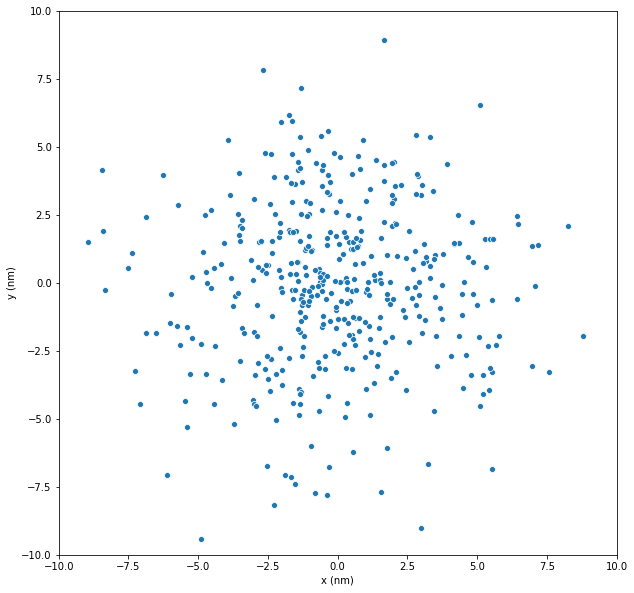

In [265]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x='step_x', y='step_y', data=t4 * NM_PER_PIXEL)
plt.xlabel("x (nm)")
plt.ylabel("y (nm)")
plt.xlim(-10, 10)
plt.ylim(-10, 10)

In [278]:
t4[t4.particle == 2]

KeyboardInterrupt: 

In [277]:
t4['step_size'] = np.sqrt(t4['step_x'] ** 2 + t4['step_y'] ** 2)
t4['big_step'] = t4['step_size'] > 10
a = ~t4['big_step']
b = a.cumsum()
c = b-b.where(~a).ffill().fillna(1).astype(int)
t4['wait'] = c
t4['wait'] = t4['wait'].replace(0, np.nan).ffill(limit=1)
t4[t4['big_step']].dropna()

,frame,y,x,mass,size,ecc,signal,raw_mass,ep,particle,step_y,step_x,step_size,big_step,wait
72,2,174.098734,39.690340,4.808615,1.830630,0.093042,0.369189,14.487905,-1.172080,2,-10.081164,6.290360,11.882697,True,17.0
229,6,158.248674,33.150365,4.715513,1.801042,0.192747,0.374976,14.515177,-0.966156,2,-11.339132,-4.092308,12.054995,True,3.0
402,12,212.608462,14.802080,4.760476,1.791610,0.163146,0.374454,13.812615,-0.620764,2,14.306489,-0.865293,14.332632,True,1.0
182,5,195.301694,97.477209,4.701746,1.843765,0.202021,0.366593,20.643393,0.374027,3,9.568686,4.251453,10.470654,True,7.0
248,7,190.415212,104.189439,4.666769,1.778071,0.221526,0.375381,21.852424,0.314147,3,-6.905670,10.350241,12.442499,True,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425,13,227.315411,178.502980,4.789136,1.720998,0.055577,0.390135,29.978425,0.136142,46,0.603529,-13.413194,13.426765,True,5.0
381,11,112.923520,152.648532,4.625103,1.758631,0.238251,0.381452,25.724478,0.165563,47,-10.487403,13.330128,16.961071,True,2.0
464,14,133.032353,129.325124,4.561296,1.730998,0.146539,0.373554,25.029457,0.196148,47,10.613575,-21.625339,24.089484,True,2.0
412,12,103.788411,227.107142,4.748199,1.724852,0.143991,0.386731,34.964996,0.083019,48,-12.947515,-5.680163,14.138684,True,1.0
